# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Introduction

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgment to classify these landmarks would not be feasible.

In this project, first steps are taken towards addressing this problem by building a landmark classifier to automatically predict the location of the image based on any landmarks depicted in the image. An end-to-end machine learning process is implemented: performing data preprocessing, designing and training CNNs, comparing the accuracy of different CNNs, and deploying an app based on the best CNN trained.

### Scope:
* Design and train a CNN from scratch
* Create transfer learning architecture
* Deploy algorithm in an app

### Designing and training a CNN from scratch

<img src="static_images/Machu_Picchu/4336abf3179202f2.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=b8492f47eead79220e8f98121ab42b72a4f3aa09b40464ad6694586f4873f6b4
  Stored in directory: /root/.cache/pip/wheels/f7/55/ff/f3d7554e69382d31cf7ad857cf518af9b923134fca7d925187
Successfully built bokeh
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
from src.helpers import setup_env

setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory /data/DLND/C2/landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Data

In [2]:
!pytest -vv src/data.py -k data_loaders

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 1 deselected / 3 selected                                  

src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 5.86s ========================


<br>

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> **Answer**: 

1. The images are resized using a combination of `T.Resize(256)` and cropping methods. Initially, each image is resized to 256 pixels on its shorter side while maintaining the aspect ratio. After resizing, the images undergo a center or random cropping step. For the training set, `T.RandomCrop(224, padding_mode="reflect", pad_if_needed=True)` is used to extract a 224x224 region, ensuring the model sees various parts of the image. For the validation and test sets, `T.CenterCrop(224)` is applied to provide a consistent and central portion of the image for evaluation.

    The choice of 224x224 for the input tensor is standard in many CNN architectures. This size provides a good balance between preserving detail and reducing computational load.


2. Yes.

    To improve the model's generalization ability, various augmentation techniques were applied to the **training set**:
  - **Random Affine Transformations:** `T.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10)` is used to randomly adjust the scale, translation, and rotation of the images. This simulates real-world variations in landmark appearances due to different viewing angles or distances.
  - **Color Jittering:** `T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)` alters the brightness, contrast, saturation, and hue, ensuring the model is robust to lighting changes.
  - **Random Horizontal Flip:** `T.RandomHorizontalFlip(0.5)` randomly flips the image horizontally with a 50% probability, helping the model learn that landmarks can appear mirrored.

**Validation and Test Sets:** For the validation and test sets, augmentation is minimized to ensure that the evaluation is on data that closely resembles real-world images without artificial distortions. The images are resized and center-cropped to 224x224, followed by normalization.

**Normalization:** The normalization step ensures that the pixel values are standardized, which helps the model converge faster and perform better during training.

### Visualize a Batch of Training Data

In [3]:
!pytest -vv src/data.py -k visualize_one_batch

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/data.py::test_visualize_one_batch PASSED                             [100%]

======================= 1 passed, 3 deselected in 5.58s ========================


Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


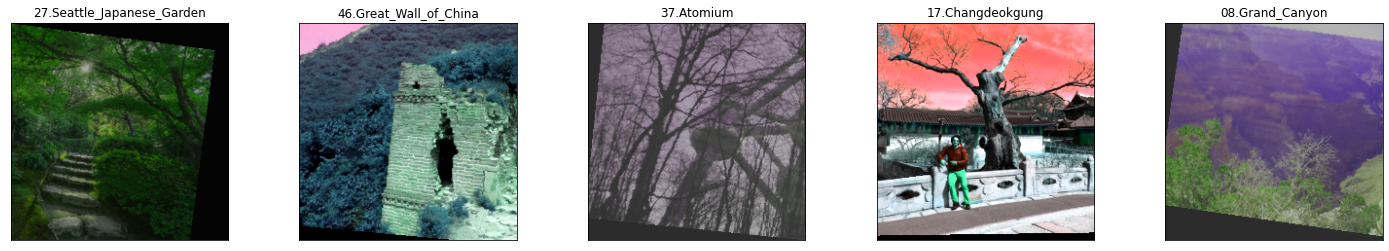

In [4]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=0, limit= -1)

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Define model

In [5]:
!pytest -vv src/model.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/model.py::test_model_construction PASSED                             [100%]

============================== 1 passed in 7.73s ===============================


<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> __Answer:__ 


My initial approach was to design a simple CNN architecture with a few convolutional layers followed by max-pooling layers. The goal was to establish a baseline performance that could be iteratively improved.
   - **Architecture:** 
     - **Conv Layers:** Two convolutional layers with ReLU activations, each followed by a max-pooling layer.
     - **Fully Connected Layers:** The output from the convolutional layers was flattened and passed through two fully connected (FC) layers before the final output layer.
     - **Reasoning:** This simple architecture allows the model to learn basic edge and texture features in the first few layers, with the FC layers responsible for combining these features for classification.

The baseline model had limited capacity, leading to underfitting, where the model was unable to capture the complexity of the landmark dataset.
   - **Enhancements:**
     - **More Convolutional Layers:** Two additional convolutional layers were added to increase the depth of the network. This allowed the model to learn more complex and abstract features at deeper levels.
     - **Increased Filters:** The number of filters in each convolutional layer was gradually increased, starting with 16 filters in the initial layers and doubling the number of filters in subsequent layers (e.g., 16 → 32 → 64 → 128).
     - **Reasoning:** Deeper networks with more filters can capture a wider variety of patterns and structures in images, essential for recognizing complex landmarks.

With the increased model capacity, overfitting became a concern, as the model performed well on the training set but poorly on the validation set.
  - **Regularization Techniques:**
     - **Dropout:** Dropout layers were introduced in the first & third convolution blocks, and after the fully connected layers. This prevents the model from relying too heavily on specific neurons, encouraging the network to generalize better.
     - **Batch Normalization:** Batch normalization was added in each convolutional layer and after the fully connected layers to stabilize learning and allow for higher learning rates.
     - **Reasoning:** These regularization techniques will help mitigate overfitting by forcing the network to learn more robust features that generalize better to unseen data.

  - **Hyperparameter Tuning:**
       - **Optimization:** The learning rate and weight_decay were systematically tuned. The model was trained with various combinations of these parameters to identify the most effective setup.
       - **Optimizer:** Switched to Adam from SGD because it led to better convergence and generalization in later stages of training.
       - **Loss:** Used CrossEntropyLoss with label smoothing. Label smoothing modifies the labels slightly to prevent the model from becoming overconfident.
       - **Reasoning:** Fine-tuning these hyperparameters ensured that the network could converge efficiently to an optimal solution.

The final architecture strikes a balance between model complexity and generalization, leading to improved performance on the landmark classification task.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: define loss and optimizer

In [6]:
!pytest -vv src/optimization.py -k get_loss

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 7 items / 6 deselected / 1 selected                                  

src/optimization.py::test_get_loss PASSED                                [100%]

======================= 1 passed, 6 deselected in 1.97s ========================


In [7]:
!pytest -vv src/optimization.py -k get_optimizer

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 7 items / 1 deselected / 6 selected                                  

src/optimization.py::test_get_optimizer_type PASSED                      [ 16%]
src/optimization.py::test_get_optimizer_is_linked_with_model PASSED      [ 33%]
src/optimization.py::test_get_optimizer_returns_adam PASSED              [ 50%]
src/optimization.py::test_get_optimizer_sets_learning_rate PASSED        [ 66%]
src/optimization.py::test_get_optimizer_sets_momentum PASSED             [ 83%]
src/optimization.py::test_get_optimizer_sets_weight_decat PASSED         [100%]

======================= 6 passed, 1 deselected in 1.88s ========================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Train and Validate the Model


In [8]:
!pytest -vv src/train.py -k train_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_train_one_epoch PASSED                                [100%]

================== 1 passed, 3 deselected in 72.70s (0:01:12) ==================


In [9]:
!pytest -vv src/train.py -k valid_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_valid_one_epoch PASSED                                [100%]

================== 1 passed, 3 deselected in 64.02s (0:01:04) ==================


In [10]:
!pytest -vv src/train.py -k optimize

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_optimize PASSED                                       [100%]

================= 1 passed, 3 deselected in 125.77s (0:02:05) ==================


In [11]:
!pytest -vv src/train.py -k one_epoch_test

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_one_epoch_test PASSED                                 [100%]

================== 1 passed, 3 deselected in 68.15s (0:01:08) ==================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything together

In the following cell we will train the model and validate it against the validation set.

Let's start by defining a few hyperparameters:

In [17]:
batch_size = 32        
valid_size = 0.2       
num_epochs = 50        
num_classes = 50       
dropout = 0.4          
learning_rate = 0.001  
opt = 'adam'            
weight_decay = 0.0003  

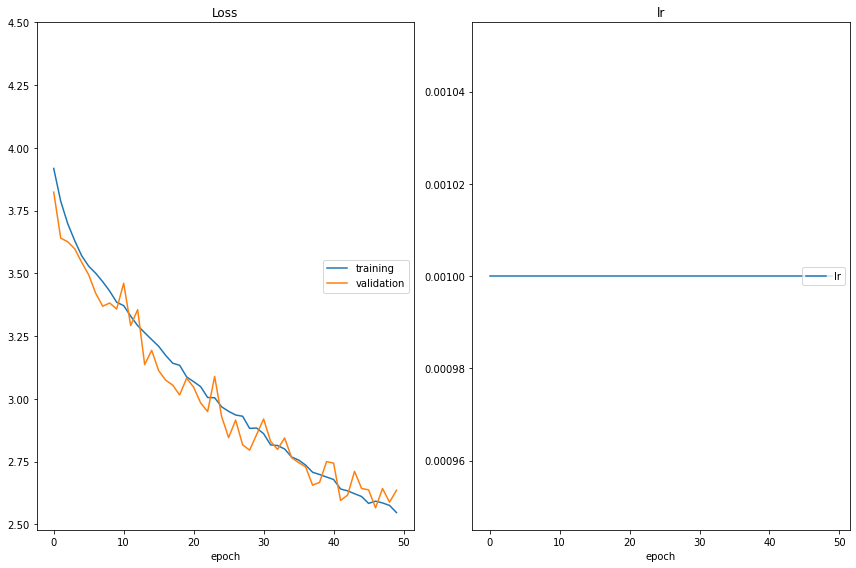

In [18]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous cell
data_loaders = get_data_loaders(batch_size=batch_size,
                                valid_size=valid_size
                               )

# instance model MyModel with num_classes and droput defined in the previous cell
model = MyModel(num_classes=num_classes,
               dropout=dropout
               )

# Get the optimizer using get_optimizer and the model just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(
    model=model,
    optimizer=opt,
    learning_rate=learning_rate,
    weight_decay=weight_decay
)

# Get loss using get_loss
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

In [19]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

#load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 40/40 [00:16<00:00,  2.37it/s]

Test Loss: 2.435778


Test Accuracy: 46% (585/1250)


2.4357778996229165

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Export using torchscript

In [20]:
!pytest -vv src/predictor.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/predictor.py::test_model_construction PASSED                         [100%]

============================== 1 passed in 9.46s ===============================


In [21]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
model = MyModel(num_classes=50, dropout=0.5).cpu()

# load the best weights found during training
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt', map_location = torch.device('cpu')))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


Making sure the exported model has the same performance as the original one, by reloading it and testing it:

In [22]:
import torch

# Load using torch.jit.load
model_reloaded =  torch.jit.load("checkpoints/original_exported.pt")

In [23]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [09:08<00:00,  2.28it/s]

Accuracy: 0.4104


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

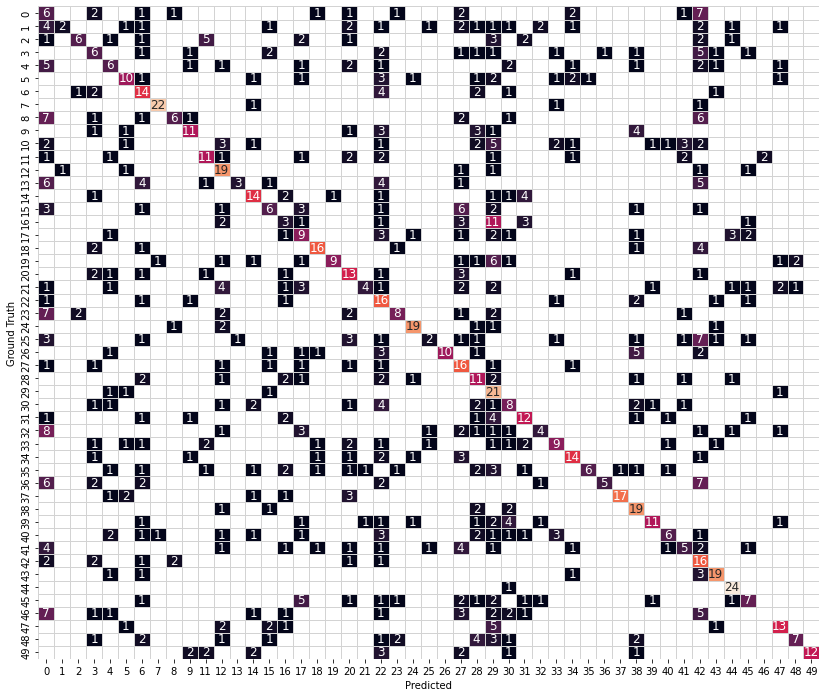

In [24]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)